# Thesis ADS: Rosa Lucassen

## Loading the data

In [96]:
import pandas as pd
import numpy as np
import pickle
import spacy
nlp = spacy.load("en_core_web_sm")
import re
from collections import Counter
import emoji
import stop_words
from scipy.stats import chi2_contingency
from urllib.parse import urlparse
from nltk.stem.porter import PorterStemmer
from gensim.corpora import Dictionary
from gensim.models.wrappers import LdaMallet

import numpy as np
import logging
import pyLDAvis.gensim
import json
import warnings
warnings.filterwarnings('ignore')  # To ignore all warnings that arise here to enhance clarity
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from numpy import array

import gensim

from gensim.models import Phrases

stemmer = PorterStemmer()

d_test = pd.read_excel("/Users/rosalucassen/Desktop/Thesis/Code/Data/Constraint_English_Test2.xlsx", engine='openpyxl')
d_train = pd.read_excel("/Users/rosalucassen/Desktop/Thesis/Code/Data/Constraint_English_Train.xlsx", engine='openpyxl')
d_val = pd.read_excel("/Users/rosalucassen/Desktop/Thesis/Code/Data/Constraint_English_Val.xlsx", engine='openpyxl')
d_test_labeled = pd.read_excel("/Users/rosalucassen/Desktop/Thesis/Code/Data/english_test_with_labels.xlsx", engine='openpyxl')

## Function: Cleaning data

In [100]:
def remove_single_char(text):
    single_char_pattern = r'\s+[a-zA-Z]\s+'
    without_sc = re.sub(pattern=single_char_pattern, repl=" ", string=text)
    return without_sc

def remove_numbers(text):
    number_pattern = r'\b(?<![0-9-])(\d+)(?![0-9-])'
    without_number = re.sub(pattern=number_pattern, repl=" ", string=text)
    return without_number


def remove_urls(text):
    url_pattern = r'https?://\S+|www\.\S+'
    without_urls = re.sub(pattern=url_pattern, repl=" ", string=text)
    return without_urls


def remove_emojis(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    without_emoji = emoji_pattern.sub(r'',text)
    return without_emoji

def remove_nonalpha(text):
    nonalpha_pattern = "[+$@#?~]"
    without_nonalpha = re.sub(pattern=nonalpha_pattern, repl=" ", string=text)
    return without_nonalpha
    
def remove_rt(text):
    rt_pattern = 'rt @[\w_]+: '
    without_pattern = re.sub(pattern = rt_pattern, repl=" ", string = text)
    return without_pattern 

def remove_extra_spaces(text):
    space_pattern = r'\s+'
    without_space = re.sub(pattern=space_pattern, repl=" ", string=text)
    return without_space

def strip_list_noempty(mylist):
    newlist = (item.strip() if hasattr(item, 'strip') else item for item in mylist)
    return [item for item in newlist if item != '']

## Function BiGrams

In [101]:
from gensim.models import Phrases
def make_n_grams(docs):
    # Add bigrams and trigrams to docs (only ones that appear 20 times or more).
    bigram = Phrases(docs, min_count=1)
    for idx in range(len(docs)):
        for token in bigram[docs[idx]]:
            if '_' in token:
                # Token is a bigram, add to document.
                docs[idx].append(token)
    return docs

## Function: Lemmatizing texts

In [102]:
def pre_processer_real(corpus):
    corpus = [text.lower() for text in corpus]
    corpus = [remove_urls(text) for text in corpus]
    corpus = [remove_single_char(text) for text in corpus]
    corpus = [remove_numbers(text) for text in corpus]
    corpus = [remove_rt(text) for text in corpus]
    corpus = [remove_emojis(text) for text in corpus]
    corpus = [remove_nonalpha(text) for text in corpus]
    corpus = [text.encode("ascii", "ignore") for text in corpus]
    corpus = [text.decode() for text in corpus]
    corpus = [remove_extra_spaces(text) for text in corpus]
    corpus = strip_list_noempty(corpus)
    
    processed_texts = [text for text in nlp.pipe(corpus, 
                                              disable=["ner",
                                                       "parser"])]
    tokenized_texts = [[word.lemma_ for word in lemma_ if not word.is_punct if not word.is_stop] 
                            for lemma_ in processed_texts]
    tokenized_texts = make_n_grams(tokenized_texts)
    
    flatten = lambda t: [item for sublist in t for item in sublist]
    flat_real = flatten(tokenized_texts)
    counts = Counter(flat_real)
    total_words = sum(counts.values()) 
    for word in counts:
        counts[word] = counts[word] * (10000) / total_words
    return counts, counts.most_common(), flat_real, tokenized_texts

def pre_processer_fake(corpus):
    corpus = [text.lower() for text in corpus]
    corpus = [remove_urls(text) for text in corpus]
    corpus = [remove_single_char(text) for text in corpus]
    corpus = [remove_numbers(text) for text in corpus]
    corpus = [remove_rt(text) for text in corpus]
    corpus = [remove_emojis(text) for text in corpus]
    corpus = [remove_nonalpha(text) for text in corpus]
    corpus = [text.encode("ascii", "ignore") for text in corpus]
    corpus = [text.decode() for text in corpus]
    corpus = [remove_extra_spaces(text) for text in corpus]
    corpus = strip_list_noempty(corpus)

    processed_texts = [text for text in nlp.pipe(corpus, 
                                              disable=["ner",
                                                       "parser"])]
    tokenized_texts = [[word.lemma_ for word in lemma_ if not word.is_punct if not word.is_stop] 
                            for lemma_ in processed_texts]
    tokenized_texts = make_n_grams(tokenized_texts)
    
    flatten = lambda t: [item for sublist in t for item in sublist]
    flat_fake = flatten(tokenized_texts)
    counts = Counter(flat_fake)
    total_words = sum(counts.values()) 
    for word in counts:
        counts[word] = counts[word] * (10000) / total_words
    return counts, counts.most_common(), flat_fake, tokenized_texts

## Function: distinctive words

In [103]:
def distinctive_words(target_corpus, reference_corpus):
    counts_c1 = Counter(target_corpus) # don't forget to flatten your texts!
    counts_c2 = Counter(reference_corpus)
    vocabulary = set(list(counts_c1.keys()) + list(counts_c2.keys()))
    freq_c1_total = sum(counts_c1.values()) 
    freq_c2_total = sum(counts_c2.values()) 
    results = []
    for word in vocabulary:
        freq_c1 = counts_c1[word]
        freq_c2 = counts_c2[word]
        freq_c1_other = freq_c1_total - freq_c1
        freq_c2_other = freq_c2_total - freq_c2
        llr, p_value,_,_ = chi2_contingency([[freq_c1, freq_c2], 
                      [freq_c1_other, freq_c2_other]],
                      lambda_='log-likelihood') 
        if freq_c2 / freq_c2_other > freq_c1 / freq_c1_other:
            llr = -llr
        result = {'word':word, 
                    'llr':llr,
                    'p_value': p_value}
        results.append(result)
    results_df = pd.DataFrame(results)
    return results_df

## Function: Topic modelling LDA Gensim

In [104]:
def topic_modelling(tokenized_text, n_topics, n_iterations):
    results = []


    dictionary = Dictionary(tokenized_text) # get the vocabulary

    corpus = [dictionary.doc2bow(text) for text in tokenized_text]

    PATH_TO_MALLET = '/Users/rosalucassen/Documents/UU/DataMining/mallet-2.0.8/bin/mallet'
    N_TOPICS = n_topics
    N_ITERATIONS = n_iterations

    lda = LdaMallet(PATH_TO_MALLET,
                    corpus=corpus,
                    id2word=dictionary,
                    num_topics=N_TOPICS,
                    iterations=N_ITERATIONS)

    for topic in range(N_TOPICS):
        words = lda.show_topic(topic, 10)
        topic_n_words = ' '.join([word[0] for word in words])
        result = {'Topic':str(topic), 
                    'Words':topic_n_words}
        results.append(result)
    results_df = pd.DataFrame(results)
    pd.set_option('display.max_colwidth', None)
    return results_df, lda, dictionary

In [106]:
# Shows all words instead of just the 10 most popular words
def topic_modelling_results(tokenized_text, n_topics, n_iterations):
    results = []

    dictionary = Dictionary(tokenized_text) # get the vocabulary
    corpus = [dictionary.doc2bow(text) for text in tokenized_text]

    PATH_TO_MALLET = '/Users/rosalucassen/Documents/UU/DataMining/mallet-2.0.8/bin/mallet'
    N_TOPICS = n_topics
    N_ITERATIONS = n_iterations

    lda = LdaMallet(PATH_TO_MALLET,
                    corpus=corpus,
                    id2word=dictionary,
                    num_topics=N_TOPICS,
                    iterations=N_ITERATIONS)
    
    for topic in range(N_TOPICS):
        words = lda.show_topic(topic)
        topic_n_words = ' '.join([word[0] for word in words])
        result = {'Topic':str(topic), 
                    'Words':topic_n_words}
        results.append(result)
    results_DF = pd.DataFrame(results)
    pd.set_option('display.max_colwidth', None)
    return results_DF, lda, dictionary

## Exploring the data

#### Training data

In [ ]:
d_train.info()

In [ ]:
d_train.head()

In [ ]:
d_train["label"].unique()

In [ ]:
grouped_train = d_train.groupby('label').count() 
grouped_train.head()

#### Validation data

In [ ]:
d_val.info()

In [ ]:
d_val.head()

In [ ]:
d_val["label"].unique()

In [ ]:
grouped_val = d_val.groupby('label').count() 
grouped_val.head()

### Test data

In [ ]:
d_test.info()

In [ ]:
d_test.head()

In [ ]:
d_test_labeled.info()

In [ ]:
d_test_labeled.head()

In [ ]:
d_test_labeled["label"].unique()

In [ ]:
grouped_test = d_test_labeled.groupby('label').count() 
grouped_test.head()

## Combine labelled data

In [107]:
data_train = pd.concat([d_train, d_test_labeled, d_val])
data_train.head()

,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,real
1,2,States reported 1121 deaths a small rise from ...,real
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,5,Populous states can generate large case counts...,real


In [108]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10700 entries, 0 to 2139
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10700 non-null  int64 
 1   tweet   10700 non-null  object
 2   label   10700 non-null  object
dtypes: int64(1), object(2)
memory usage: 334.4+ KB


In [109]:
grouped_train = data_train.groupby('label').count() 
grouped_train.head()

,id,tweet
label,,
fake,5100,5100
real,5600,5600


In [110]:
nlp.vocab["covid"].is_stop = True
nlp.vocab["corona"].is_stop = True
nlp.vocab["covid19"].is_stop = True
nlp.vocab["covid-19"].is_stop = True
nlp.vocab["corona"].is_stop = True
nlp.vocab["coronavirus"].is_stop = True

## Results: Pre-processing (before manually removing COVID-19 stopwords)

In [111]:
corpus_train_fake = data_train[data_train.label == "fake"]["tweet"]
corpus_train_real = data_train[data_train.label == "real"]["tweet"]
word_count_fake, output_fake, flat_fake, tokenized_texts_fake = pre_processer_fake(corpus_train_fake)
print(output_fake[:20])
word_count_real, output_real, flat_real, tokenized_texts_real = pre_processer_real(corpus_train_real)
print(output_real[:20])

[('say', 82.5959549528844), ('claim', 74.83911744426568), ('people', 72.82808549758676), ('virus', 63.34750632038612), ('vaccine', 58.17628131464031), ('trump', 56.02160422891289), ('pandemic', 52.861411169846015), ('case', 52.861411169846015), ('new', 52.574120891749025), ('test', 50.419443806021604), ('video', 46.97196046885773), ('india', 46.97196046885773), ('hospital', 45.82279935646978), ('death', 41.51344518501494), ('president', 39.789703516433), ('show', 39.646058377384506), ('die', 38.92783268214204), ('cure', 38.209606986899566), ('lockdown', 35.91128476212365), ('patient', 34.18754309354171)]
[('case', 267.4742952056835), ('test', 163.4815891385396), ('report', 133.69201187972232), ('new', 132.0671258474232), ('state', 123.7621527934499), ('number', 95.41691867445408), ('death', 94.24338987334916), ('total', 79.25832979770169), ('people', 70.68254240501187), ('confirm', 65.98842720059218), ('amp', 63.64136959838233), ('day', 62.558112243516256), ('today', 57.86399703909656)

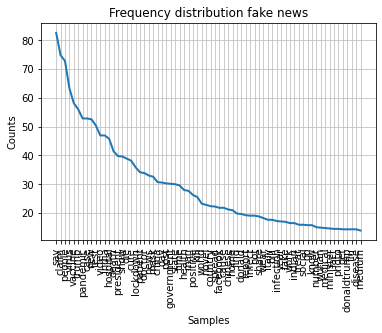

<AxesSubplot:title={'center':'Frequency distribution fake news'}, xlabel='Samples', ylabel='Counts'>

In [112]:
import nltk
from nltk import FreqDist
fdist_filtered = FreqDist(word_count_fake)
fdist_filtered.plot(70,title='Frequency distribution fake news')

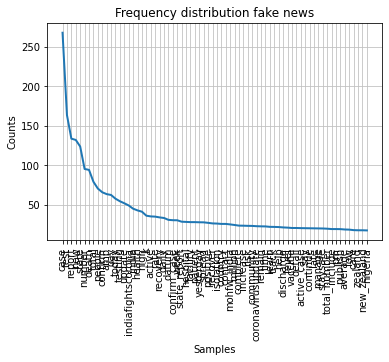

<AxesSubplot:title={'center':'Frequency distribution fake news'}, xlabel='Samples', ylabel='Counts'>

In [113]:
fdist_filtered = FreqDist(word_count_real)
fdist_filtered.plot(70,title='Frequency distribution fake news')

So, lets try removing "coronavirus", "covid-19" and "covid19".

The fake news dataset had: 
- 2129x "coronavirus" 
- 1601x "covid-19"
- 372x "covid19"

The real news dataset had:
- 2963x "case"
- 2216x "covid19"
- 1811x "case"
- 1481x "report"
- 1463x "new"
- 1371x "state"
- 1146x "covid-19"
- 575x "coronavirus"

## Results: Topic modelling LDA Gensim

#### Fake news

In [114]:
topics, lda_fake, dictionary = topic_modelling_results(tokenized_texts_fake, 5, 400)
topics

,Topic,Words
0,0,people pandemic death lockdown state case italy infection number flu
1,1,virus test cure news day kill positive world find infect
2,2,claim video hospital show die patient doctor post time vaccine
3,3,mask china government man spread chinese wear year work wuhan
4,4,trump president vaccine india health case country donald report fact


In [115]:
# Compute Coherence Score using c_v
coherence_model_lda = CoherenceModel(model=lda_fake, texts=tokenized_texts_fake, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.44484759625892306


- Two topics:     c_v = 0.535
- Three topics:   c_v = 0.4999
- Four topics:    c_v = 0.440
- Five topics :   c_v = 0.4562
- Six topics:     c_v = 0.387
- Seven topics:   c_v = 0.367
- Eight topics:   c_v = 0.406
- Nine topics:    c_v = 0.4006

- Ten topics:     c_v = 0.4048
- Eleven topics:  c_v = 0.3759
- Twelve topics:  c_v = 0.372
- Thirteen topics:c_v = 0.3959
- Fourteen topics:c_v = 0.3869
- Fifteen topics: c_v = 0.3956

- Twenty topics:  c_v = 0.4009
- Fourty topics:  c_v = 0.41147
- Fifty topics:   c_v = 0.4391
- Sixty topics:   c_v = 0.4329
- Seventy topics: c_v = 0.443
- Eighty topics:  c_v = 0.4402

#### Real news

In [116]:
topics_real, lda_real, dictionary = topic_modelling_results(tokenized_texts_real, 20, 400)
topics_real

,Topic,Words
0,0,spread face mask wear protect amp public slow hand learn
1,1,state datum number hospitalization report york new_york alexismadrigal large positive
2,2,case confirm death nigeria pm april report state confirm_case discharge
3,3,case total test confirm complete state bring date yesterday bring_total
4,4,amp testing health lab capacity response service public_health national public
5,5,death case covid19nigeria show case_covid19nigeria confirm south discharge cdc late
6,6,case isolation facility community manage positive manage_isolation quarantine update auckland
7,7,contact amp close result virus clinical treatment travel lead early
8,8,test report state update daily state_report track million publish daily_update
9,9,home infection high outbreak level person area issue place base


In [117]:
# Compute Coherence Score using c_v
coherence_model_lda = CoherenceModel(model=lda_real, texts=tokenized_texts_real, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.48230457915828195


## Find optimal number of topics method 1

In [118]:
def compute_coherence_values(texts, start, step, limit):
    dictionary = Dictionary(texts) # get the vocabulary
    dictionary.filter_extremes(no_below=5, no_above=0.5)
    corpus = [dictionary.doc2bow(text) for text in texts]

    PATH_TO_MALLET = '/Users/rosalucassen/Documents/UU/DataMining/mallet-2.0.8/bin/mallet'
    
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(PATH_TO_MALLET, corpus=corpus, num_topics=num_topics, id2word=dictionary, alpha=0.05)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [119]:
#Using the c_v measure
model_list, coherence_values = compute_coherence_values(texts=tokenized_texts_fake, start=1, step=1, limit=6)

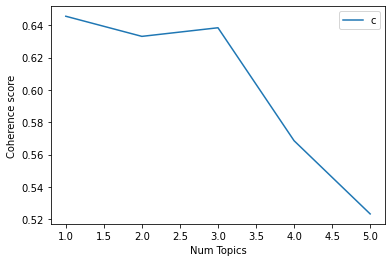

In [120]:
#Using the c_v measure
#model_list, coherence_values = compute_coherence_values(texts=tokenized_texts_fake, start=2, limit=40, step=6)
# Show graph
import matplotlib.pyplot as plt
limit=6; start=1; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [121]:
#Using the c_v measure
model_list, coherence_values = compute_coherence_values(texts=tokenized_texts_real, start=5, step=1, limit=22)

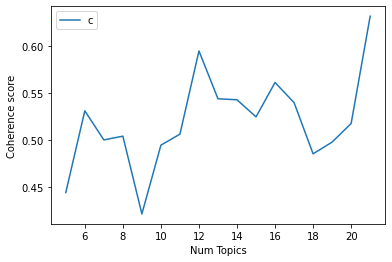

In [122]:
# Show graph
import matplotlib.pyplot as plt
limit=22; start=5; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

## Hierarchical Dirichlet Process

#### fake news

In [35]:
from gensim.models import CoherenceModel, HdpModel

In [75]:
dictionary = Dictionary(tokenized_texts_fake) # get the vocabulary
dictionary.filter_extremes(no_below=5, no_above=0.5)
corpus = [dictionary.doc2bow(text) for text in tokenized_texts_fake]
PATH_TO_MALLET = '/Users/rosalucassen/Documents/UU/DataMining/mallet-2.0.8/bin/mallet'

hdpmodel = HdpModel(corpus=corpus, id2word=dictionary)

In [76]:
hdptopics = hdpmodel.show_topics(formatted=False)
hdptopics[0]


(0,
 [('vaccine', 0.004065842760676151),
  ('people', 0.0037297931012434393),
  ('video', 0.0030327631373317345),
  ('claim', 0.002946636986228348),
  ('say', 0.0029228472314025353),
  ('show', 0.0029222882480462423),
  ('india', 0.0027376072939392063),
  ('disaster_management', 0.002614386162004252),
  ('potential', 0.002608091661913182),
  ('new', 0.002572729416240101),
  ('planet', 0.0024994377936871214),
  ('hospital', 0.002492766010365907),
  ('president', 0.0024922720581707744),
  ('tamil_nadu', 0.002476577027169748),
  ('die', 0.0024611977020038028),
  ('cruise', 0.0023669316967782233),
  ('patient', 0.0022611652658057566),
  ('learn', 0.00203852960241749),
  ('elizabeth', 0.0020368712137134115),
  ('journalist', 0.002024261652860105)])

In [45]:
len(hdptopics)

20

In [77]:
hdptopics = [[word for word, prob in topic] for topicid, topic in hdptopics]

In [78]:
coherence_values_fake = []
model_list = []
for num_topics in range(1, 40):
    coherencemodel = CoherenceModel(topics=hdptopics[:num_topics], 
                               texts=tokenized_texts_fake, 
                               dictionary=dictionary, 
                               window_size=10).get_coherence()
    coherence_values_fake.append(coherencemodel)
    

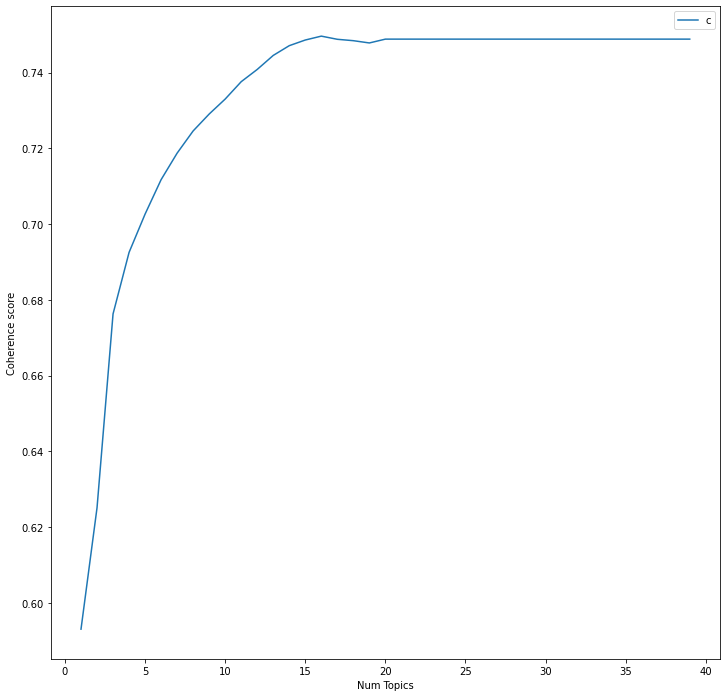

In [79]:
limit=40; start=1; step=1;
x = range(start, limit, step)
plt.figure(figsize=(12,12))
plt.plot(x, coherence_values_fake)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

#### Real news

In [80]:
dictionary = Dictionary(tokenized_texts_real) # get the vocabulary
dictionary.filter_extremes(no_below=5, no_above=0.5)
corpus = [dictionary.doc2bow(text) for text in tokenized_texts_real]
PATH_TO_MALLET = '/Users/rosalucassen/Documents/UU/DataMining/mallet-2.0.8/bin/mallet'

hdpmodel = HdpModel(corpus=corpus, id2word=dictionary)

In [81]:
hdptopics = hdpmodel.show_topics(formatted=False)
hdptopics[0]

(0,
 [('case', 0.019865530420898152),
  ('report', 0.010002485756322236),
  ('new', 0.009092768458727404),
  ('number', 0.009047338876319897),
  ('confirm', 0.0064132676714569225),
  ('total', 0.006347752261825253),
  ('death', 0.005446956037797163),
  ('state', 0.005372075017211056),
  ('confirm_case', 0.004440257648475645),
  ('total_number', 0.003971773850847443),
  ('today', 0.0038085318226021075),
  ('active', 0.003224424172979948),
  ('recover', 0.003007809207100933),
  ('test', 0.0029341150276266186),
  ('health', 0.002800112234747253),
  ('new_zealand', 0.002713965291875611),
  ('organization', 0.002655447946364924),
  ('hospital', 0.00254984678967476),
  ('facility', 0.0024804915734108457),
  ('report_world', 0.0023988214670042723)])

In [82]:
len(hdptopics)

20

In [83]:
hdptopics = [[word for word, prob in topic] for topicid, topic in hdptopics]

In [84]:
coherence_values_real = []
model_list = []
for num_topics in range(1, 40):
    coherencemodel = CoherenceModel(topics=hdptopics[:num_topics], 
                               texts=tokenized_texts_real, 
                               dictionary=dictionary, 
                               window_size=10).get_coherence()
    coherence_values_real.append(coherencemodel)

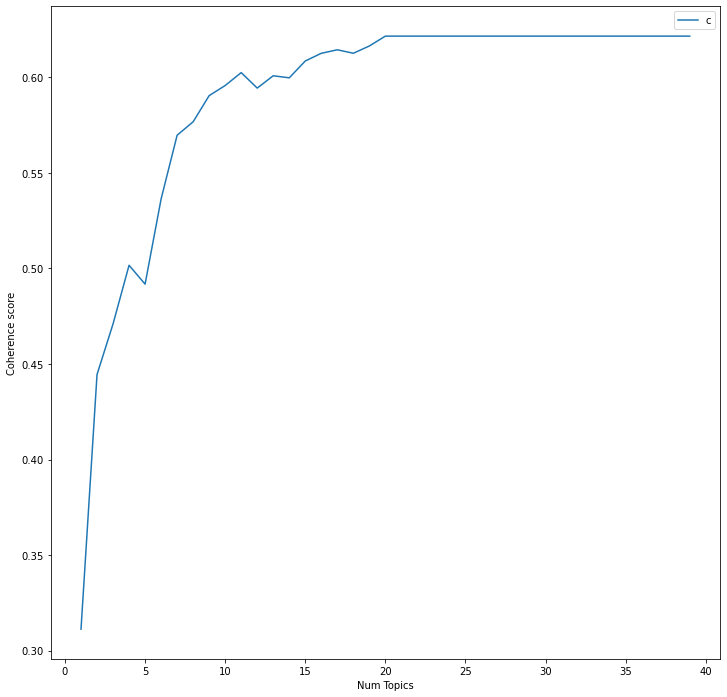

In [85]:
limit=40; start=1; step=1;
x = range(start, limit, step)
plt.figure(figsize=(12,12))
plt.plot(x, coherence_values_real)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [48]:
def evaluate_bar_graph(coherences, indices):
    assert len(coherences) == len(indices)
    n = len(coherences)
    x = np.arange(n)
    plt.figure(figsize=(12,12))
    plt.bar(x, coherences, width=0.2, tick_label=indices, align='center')
    plt.xlabel('Models')
    plt.ylabel('Coherence Value')

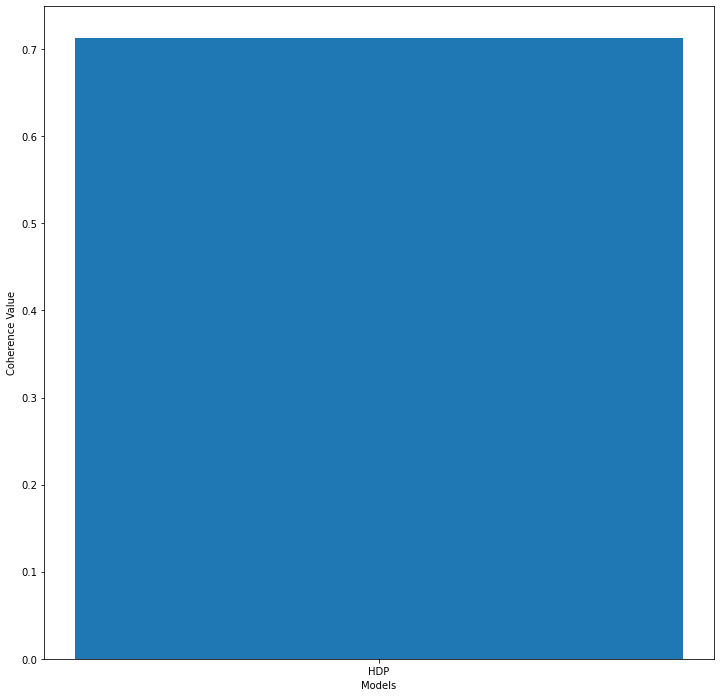

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline
evaluate_bar_graph([hdp_coherence],
                   ['HDP'])

## Document topic distribution

###### Loop over documents to get topic distribution: Fake

In [ ]:
transformed_docs = lda_fake.load_document_topics()

In [ ]:
for i, document in enumerate(transformed_docs):
    print('Topic distributions for document {}'.format(i))
    for topic in document:
        print(topic)

In [ ]:
transformed_docs = lda_fake.load_document_topics()
topic_distributions_fake = pd.DataFrame([[x[1] for x in doc] for doc in transformed_docs], 
             columns=['topic_{}'.format(i) for i in range(8)])
topic_distributions_fake.tail()
topic_distributions_fake.mean().sort_values(ascending=False)

###### Loop over documents to get topic distribution: Real

In [ ]:
transformed_docs = lda_real.load_document_topics()
for i, document in enumerate(transformed_docs):
    print('Topic distributions for document {}'.format(i))
    for topic in document:
        print(topic)

In [ ]:
transformed_docs = lda_real.load_document_topics()
topic_distributions_real = pd.DataFrame([[x[1] for x in doc] for doc in transformed_docs], 
             columns=['topic_{}'.format(i) for i in range(20)])
topic_distributions_real.tail()
#topic_distributions.mean().sort_values(ascending=False)

## Find optimal number of topics using Gensim method 2

This methods takes a very long time, but will also give alpha and beta values

In [ ]:
def compute_coherence_values(corpus, dictionary, k, a, b):
    lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=k, alpha = a, eta = b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_texts_fake, dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()
    

In [ ]:
import numpy as np
import tqdm
grid = {}

dictionary = Dictionary(tokenized_texts_real) # get the vocabulary
dictionary.filter_extremes(no_below=5, no_above=0.5)
corpus = [dictionary.doc2bow(text) for text in tokenized_texts_real]
PATH_TO_MALLET = '/Users/rosalucassen/Documents/UU/DataMining/mallet-2.0.8/bin/mallet'

#grid['Validation_Set'] = {}
# Topics range
min_topics = 5
max_topics = 40
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')
# Validation sets
#corpus = [dictionary.doc2bow(text) for text in tokenized_texts_real]
num_of_docs = len(corpus)
#corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               #gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               #corpus]
#corpus_title = ['75% Corpus', '100% Corpus']
model_results = {#'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=270)
    
    # iterate through validation corpuses
    #for i in range(len(corpus_sets)):
        # iterate through number of topics
    for k in topics_range:
        # iterate through alpha values
        for a in alpha:
            # iterare through beta values
            for b in beta:
                # get the coherence score for the given parameters
                cv = compute_coherence_values(corpus=corpus, dictionary=dictionary, k=k, a=a, b=b)
                # Save the model results
                #model_results['Validation_Set'].append(corpus_title[i])
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Beta'].append(b)
                model_results['Coherence'].append(cv)
                    
                pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results_real.csv', index=False)
    pbar.close()

## Results: Most distinctive words
This gives an extreme output, why?

In [ ]:
results_df = distinctive_words(flat_real, flat_fake)
results_df.sort_values('llr', ascending=False).head(5)